In [204]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import datetime as dt
from statistics import stdev
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from IPython.display import clear_output
import numpy as np
import random
random.seed(42)
sys_random = random.SystemRandom()
import joblib
import pickle
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [205]:
def read_files():
    train =[]
    test =[]
    RUL =[]
    for i in range(0,4):
        train.append(pd.read_csv('/home/jovyan/rul-remaining-useful-life/train_FD00'+str(i+1)+'.txt', delimiter=" ", decimal=".", header=None))
#         test.append(pd.read_csv('test_FD00'+str(i+1)+'.txt',  delimiter=" ", decimal=".", header=None))
#         RUL.append(pd.read_csv('RUL_FD00'+str(i+1)+'.txt',  delimiter=" ", decimal=".", header=None))
    return(train)

In [206]:
def remove_mssng_df(dfs, cols):
    cln= []
    for df in dfs:
        df.drop(df.columns[list(df.columns[df.isnull().sum() > 0])], axis=1, inplace=True)
        df.columns = cols
        cln.append(df)
    return(cln)

In [207]:
def add_RULS(dfs):
    df1=[]
    tr_units = []
    for df in dfs:
        tr_units.append(df.groupby('unit', as_index=False)['cycles'].agg('max'))
        df = pd.merge(df, df.groupby('unit', as_index=False)['cycles'].agg('max'),how='left', on='unit')
        df.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
        df['RUL'] = df['maxcycles'] - df['cycles']
#         df['ULfrac']= df['cycles'].divide(df['max'])
        df1.append(df)
#         tr_units.append(df[['unit', 'cycles']])
    return(df1, tr_units)

In [208]:
cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [209]:
features = ['op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [210]:
trains= read_files()
trains= remove_mssng_df(trains, cols)
trains,tr_units = add_RULS(trains)

In [211]:
def lived_but_died(df, lower=150, delta=50):
    upper= lower+delta
    df['target']=2
    df.loc[(df.cycles >=lower),'target']=0
    df.loc[((df.cycles >=lower) & (df.cycles < upper)), 'target']=1
    df=df.loc[df.target!=2]
    return(df)

In [212]:
target= lived_but_died(tr_units[1], 150, 50)

In [213]:
train= trains[1]

In [214]:
def cycle_cut(target, train, lower=100,wind=50):
    cycls = list(range(lower-wind, lower+1))
    units= np.array(target.loc[target.target!=2].unit)
    left= train.loc[train.cycles.isin(cycls)].loc[train.unit.isin(units)].groupby(['unit']).agg('mean').reset_index()
    data = left.merge(target, left_on= 'unit', right_on='unit')
    return(data)

In [215]:
data= cycle_cut(target, train, 150, 50)

In [216]:
def build_model(data, target, features):
    X= data.loc[:,features].values
    scaler = MinMaxScaler()
    scale= scaler.fit(X)
    X= scale.transform(X)
    y= data.target.values
    clf = LogisticRegression(random_state=42,solver='saga', max_iter=1000, penalty='l1').fit(X, y)
    return(clf,scale,X)

In [224]:
def calc_ks_2samp(tr_X, X, features):
    ks_scores=[]
    null_rej=[]
    dim= tr_X.shape[1]
    for d in range(dim):
        d1= tr_X[:,d]
        d2= X[:,d]
        ks=stats.ks_2samp(d1, d2, alternative='two-sided')
        ks_scores.append(ks)
        if ks[1] < .01:
            null_rej.append(features[d])
        
    return(np.array(ks_scores), null_rej)

In [217]:
def calculate_psi(expected, actual, buckettype='quantiles', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [218]:
clf, scale,X= build_model(data, target, features)

In [219]:
ypred= clf.predict(scale.transform(data.loc[:,features].values))
y= data.target.values

In [220]:
f1_score(y,ypred)

0.751131221719457

In [221]:
lowers= [150,250]
files= [1,3]
clfs={}
for file in files:
    train= trains[file]
    tr_unit= tr_units[file]
    for lower in lowers:
        key= file*1000+lower
        target= lived_but_died(tr_unit, lower, 50)
        data = cycle_cut(target, train, lower)
        clf,scale,X= build_model(data, target, features)
        print(key)
        clfs[key]= [clf,scale,X]

1150
1250
3150
3250


In [222]:
all_scores={}
for k, v in clfs.items():
    clf= v[0]
    scale= v[1]
    tr_X= v[2]
    scores= {}
    for k1 in clfs.keys():
        file = k1//1000
        lower = k1%1000
        train= trains[file]
        tr_unit= tr_units[file]
        target= lived_but_died(tr_unit, lower, 50)
        data = cycle_cut(target, train, lower)
        X= data.loc[:,features].values
        X= scale.transform(X)
        y= data.target.values
        ypred= clf.predict(X)
        yscore= clf.predict_proba(X)
        psi=calculate_psi(X, tr_X, 'bins', 10,1)
        res = sorted(range(len(psi)), key = lambda sub: psi[sub])[-5:]
        psi_list=[]
        for r in res:
            psi_list.append(features[r])
        kstat, null_rej= calc_ks_2samp(tr_X, X, features)
        curve= roc_curve(y, ypred)
        print('==================================================')
        print('Built On:', k, 'Scored On:',k1)
#         print('KS:', kstat)
        print('features rej null hypo:', null_rej)
        print('PSIs:', psi_list)
        print('F1:',round(f1_score(y, ypred),2),'Precision:',round(precision_score(y, ypred),2),\
                'Recall:', round(recall_score(y, ypred),2),'ROC:',round(roc_auc_score(y, ypred),2),\
                'Confusion Matrix:', confusion_matrix(y, ypred))
        print("==================================================")
    scores[k1] = {'PSI':round(np.mean(psi),2),'F1':round(f1_score(y, ypred),2),'Precision':round(precision_score(y, ypred),2),\
                'Recall': round(recall_score(y, ypred),2),'ROC':round(roc_auc_score(y, ypred),2),\
                'Confusion Matrix': confusion_matrix(y, ypred)}
    all_scores[k]= scores
    
#             scores[k1]= [f1_score(y, ypred), precision_score(y, ypred), recall_score(y, ypred), roc_auc_score(y, yscore)]

Built On: 1150 Scored On: 1150
features rej null hypo: []
PSIs: ['s17', 's18', 's19', 's20', 's21']
F1: 0.75 Precision: 0.75 Recall: 0.75 ROC: 0.77 Confusion Matrix: [[102  27]
 [ 28  83]]
Built On: 1150 Scored On: 1250
features rej null hypo: ['s11', 's13', 's14', 's16']
PSIs: ['s6', 's20', 's14', 'op_setting2', 's17']
F1: 0.89 Precision: 0.88 Recall: 0.91 ROC: 0.79 Confusion Matrix: [[ 8  4]
 [ 3 29]]
Built On: 1150 Scored On: 3150
features rej null hypo: ['s11', 's15']
PSIs: ['op_setting1', 's20', 's18', 'op_setting2', 's7']
F1: 0.75 Precision: 0.85 Recall: 0.66 ROC: 0.81 Confusion Matrix: [[159   8]
 [ 24  47]]
Built On: 1150 Scored On: 3250
features rej null hypo: ['s14', 's15']
PSIs: ['s12', 's18', 's17', 's16', 'op_setting2']
F1: 0.57 Precision: 0.88 Recall: 0.43 ROC: 0.68 Confusion Matrix: [[49  3]
 [31 23]]
Built On: 1250 Scored On: 1150
features rej null hypo: ['s11', 's13', 's14', 's16']
PSIs: ['s1', 's17', 's2', 'op_setting3', 's10']
F1: 0.63 Precision: 0.46 Recall: 1.0 ROC

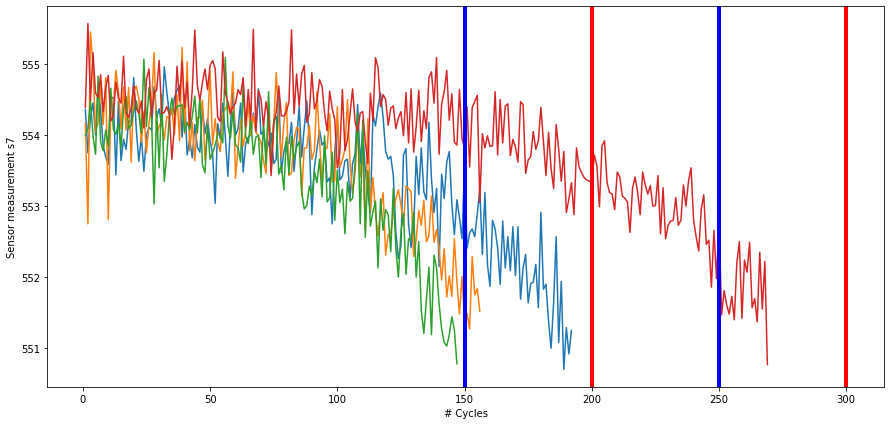

In [140]:
plt.figure(figsize = (15, 7))
plt.plot(df1[df1.unit==1].cycles, df1[df1.unit==1].s7)
plt.plot(df1[df1.unit==98].cycles, df1[df1.unit==98].s7)
plt.plot(df1[df1.unit==24].cycles, df1[df1.unit==24].s7)
plt.plot(df1[df1.unit==5].cycles, df1[df1.unit==5].s7)
# plt.plot(df1[df1.unit==11].cycles, df1[df1.unit==11].s13)
plt.axvline(x=150, linewidth=4, color='b')
plt.axvline(x=200, linewidth=4, color='r')
plt.axvline(x=250, linewidth=4, color='b')
plt.axvline(x=300, linewidth=4, color='r')
plt.xlabel('# Cycles')
plt.ylabel('Sensor measurement s7')
plt.show()